In [7]:
"""
GP emulation
"""
##### Packages ###############
import numpy as np  
import matplotlib.pylab as plt
import time
import pickle
import os
from sklearn.decomposition import PCA
# import GPy
import matplotlib.ticker as ticker
import gpflow


In [8]:
############################# PARAMETERS ##############################

dataDir = "./Data/Fixedn/" ## Data folder
modelDir = "./Models/Fixedn/" ## Data folder
plotsDir = "./Plots/Fixedn/" ## Data folder

nRankMax = [2, 4, 8, 12, 16, 32][4]  ## Number of basis vectors in truncated PCA
## Increasing nRankMax will increase emulation precision (asymptotically), but reduce the speed

# del_idx = [5, 25, 4, 42]  ## Random holdouts (not used in training, reserved for validation) 
# del_idx = [4]  ## Random holdouts (not used in training, reserved for validation) 
# del_idx = [11, 17, 20, 37, 46]  ## Random holdouts (not used in training, reserved for validation) 
# del_idx = [11, 5, 4, 42]  ## Random holdouts (not used in training, reserved for validation) 
del_idx = [11]  ## Random holdouts (not used in training, reserved for validation) 

# 11, 17, 20, 37, 46, 
# DONOT use these: (array([22, 15, 19, 20, 35]), array([27, 34, 30, 29, 14])) -- edge cases
snap_ID = 96 ## NOT 97


############################# PARAMETERS ##############################


fileIn = dataDir + 'ratiosbinsnew_' + str(snap_ID) + '.txt'
paramIn = dataDir + 'mg_log.design'



# paramIn = dataDir + 'mg.design'
# fileIn = dataDir + ['ratios.txt', 'PMG.txt'][0]



# plotsDir = "./Plots/" ## Data folder
# dataDir = "./Data/Emulator_data/" ## Data folder
# dataDir = "./Data/Emulator213bins/" ## Data folder

# paramIn = dataDir + 'mg.design'  ## parameter file



az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
fileIn = dataDir + 'ratiosbinsnew_' + str(snap_ID) + '.txt'

### GPmodel = modelDir + 'a89003GPflow_model_213Smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary
# GPmodel = modelDir + 'a89004GPflow_model_213Smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary
GPmodel = modelDir + 'nCorrLogfixedGP_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary
PCAmodel = modelDir + 'nCorrLogfixedPCA_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary

print(GPmodel)
################################# I/O #################################


./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap96


In [13]:
loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]

parameter_array_all = np.loadtxt(paramIn)

In [14]:
parameter_array_all[:, 3] = np.log10(parameter_array_all[:, 3])

In [15]:



# ############## rescaling ##############


# def rescale01(f):
#     return np.min(f), np.max(f), (f - np.min(f)) / (np.max(f) - np.min(f))


# lhd = np.zeros_like(parameter_array_all)
# for i in range(parameter_array_all.shape[1]):
#     _, _, lhd[:, i] = rescale01(parameter_array_all[:, i])
   

# parameter_array_all = lhd

# # _,_,PmPl_all = rescale01(loadFile[:, 1:].T)









############## rescaling ##############


def rescale01(f):
    return np.min(f), np.max(f), (f - np.min(f)) / (np.max(f) - np.min(f))


def scale01(fmin, fmax, f):
    return (f - fmin) / (fmax - fmin)
#     return f*(fmax - fmin) + fmin


lhd = np.zeros_like(parameter_array_all)
lhdmin = np.zeros_like(parameter_array_all[1])
lhdmax = np.zeros_like(parameter_array_all[1])

for i in range(parameter_array_all.shape[1]):
    lhdmin[i], lhdmax[i], lhd[:, i] = rescale01(parameter_array_all[:, i])
   

parameter_array_all = lhd
np.savetxt(dataDir+'paralims_nCorr.txt', np.array([lhdmin, lhdmax]))


############## rescaling ##############


## Removing hold-out test points
parameter_array = np.delete(parameter_array_all, del_idx, axis=0)
PmPl = np.delete(PmPl_all, del_idx, axis=0)



In [16]:
lhdmin, lhdmax = np.loadtxt(dataDir + 'paralims_nCorr.txt')

In [17]:
#### adding smoothing filter ########

import scipy.signal
yhat = scipy.signal.savgol_filter(PmPl[:,:], 51, 3) # window size 51, polynomial order 3
y_train = yhat

####################################

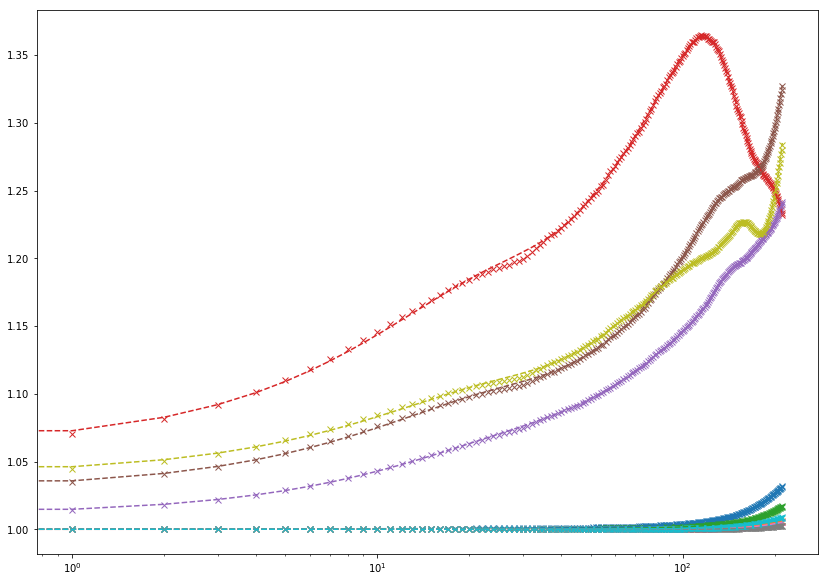

In [18]:
import scipy.signal

yhat = scipy.signal.savgol_filter(y_train, 51, 3) # window size 51, polynomial order 3


plt.figure(121, (14,10))
plt.plot( np.array(y_train).T[:,0:10], 'x')
plt.plot( np.array(yhat).T[:,0:10], '--')
plt.xscale('log')

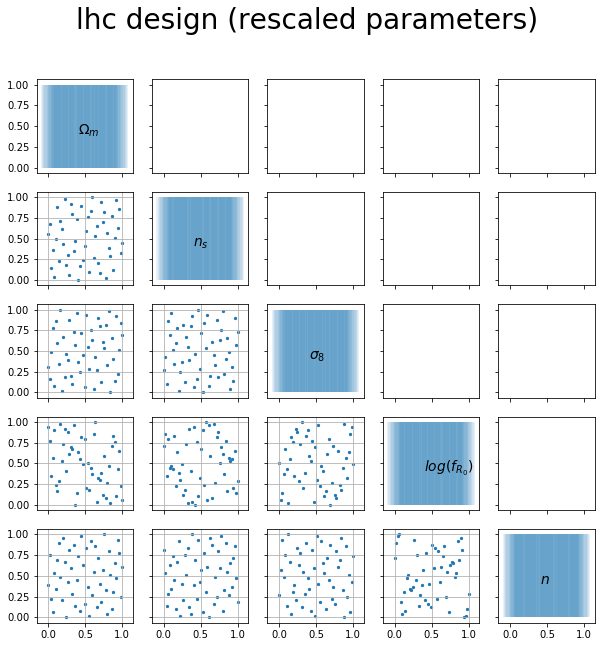

In [19]:
############################# Plot the input parameter distribution ##############################

allLabels = [r'${\Omega}_m$', r'$n_s$', r'${\sigma}_8$', r'$log(f_{R_0})$', r'$n$']


lhd = np.zeros_like(parameter_array_all)
for i in range(parameter_array_all.shape[1]):
    _,_,lhd[:, i] = rescale01(parameter_array_all[:, i])
    
def plot_params(lhd):
    f, a = plt.subplots(lhd.shape[1], lhd.shape[1], sharex=True, sharey=True, figsize=(10, 10) )
    plt.suptitle('lhc design (rescaled parameters)', fontsize = 28)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.rcParams.update({'font.size': 8})

    for i in range(lhd.shape[1]):
        for j in range(i + 1):
            # print(i, j)
            if (i != j):
                a[i, j].scatter(lhd[:, i], lhd[:, j], s=5)
                a[i, j].grid(True)
            else:
                hist, bin_edges = np.histogram(lhd[:, i], density=True, bins=64)
                a[i, i].text(0.4, 0.4, allLabels[i], size = 'xx-large')

                a[i, i].bar(bin_edges[:-1], hist / hist.max(), width=0.2, alpha = 0.1)


    plt.show()


plot_params(lhd)

In [20]:
########################### PCA ###################################
# set up pca compression
from sklearn.decomposition import PCA


def PCA_compress(x, nComp):
    # x is in shape (nparams, nbins)
    pca_model = PCA(n_components=nComp)
    principalComponents = pca_model.fit_transform(x)
    pca_bases = pca_model.components_

    print("original shape:   ", x.shape)
    print("transformed shape:", principalComponents.shape)
    print("bases shape:", pca_bases.shape)

    import pickle
    pickle.dump(pca_model, open(PCAmodel, 'wb'))

    return pca_model, np.array(principalComponents), np.array(pca_bases)


######################## GP FITTING ################################

## Build GP models
# This is evaluated only once for the file name. GP fitting is not required if the file exists.
  

def GPflow_fit(parameter_array, weights, fname= GPmodel):
    # kern = gpflow.kernels.Matern52(input_dim = np.shape(parameter_array)[1], ARD=True)
    # kern = gpflow.kernels.Matern12(input_dim = np.shape(parameter_array)[1], ARD=False)
    # kern = gpflow.kernels.Matern32(input_dim = np.shape(parameter_array)[1], ARD=True)
    # kern = gpflow.kernels.RBF(input_dim = np.shape(parameter_array)[1], ARD=True)

    kern1 = gpflow.kernels.RBF(input_dim = np.shape(parameter_array)[1], ARD=True)
    kern2 = gpflow.kernels.RBF(input_dim = np.shape(parameter_array)[1], ARD=False)

    kern = kern1 + kern2


#     m1 = GPy.models.GPRegression(parameter_array, weights, kernel=kern)
    m = gpflow.models.GPR(parameter_array, weights, kern=kern, mean_function=None)
#     print_summary(m)
    # m.likelihood.variance.assign(0.01)
    # m.likelihood.variance.assign(1.0)
    # m.likelihood.variance.assign(5.0)

##     m.kern.lengthscales.assign([0.3, 0.1, 0.2, 0.3, 0.1])
    # m.kern.lengthscales.assign([25, 65, 15 ,1, 1])
    # m.kern.lengthscales.assign(0.5)
    
    opt = gpflow.train.ScipyOptimizer()
    opt.minimize(m)
    m.as_pandas_table()
    
    from pathlib import Path

    # print(f'GPR lengthscales =', m.kern.lengthscales.value)

    
    path = Path(GPmodel)
    if path.exists():
        path.unlink()
    
    saver = gpflow.saver.Saver()
    saver.save(fname, m)
    



In [21]:
# ######################## GP PREDICTION FUNCTIONS ###############################


# def GPy_predict(para_array):
#     m1p = m1.predict_f(para_array)  # [0] is the mean and [1] the predictive
#     W_predArray = m1p[0]
#     W_varArray = m1p[1]
#     return W_predArray, W_varArray


# def Emu(para_array):
#     if len(para_array.shape) == 1:
#         W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))
#         x_decoded = pca_model.inverse_transform(W_predArray)
#         return np.squeeze(x_decoded)#[0]

# def EmuPlusMinus(para_array):
#     if len(para_array.shape) == 1:
#         W_predArray, W_varArray = GPy_predict(np.expand_dims(para_array, axis=0))
#         x_decoded = pca_model.inverse_transform(W_predArray)
#         x_decoded_plus = pca_model.inverse_transform(W_predArray + np.sqrt(W_varArray))
#         x_decoded_minus = pca_model.inverse_transform(W_predArray - np.sqrt(W_varArray))
#         return np.squeeze(x_decoded), np.squeeze(x_decoded_plus), np.squeeze(x_decoded_minus)


In [22]:
def scale01(fmin, fmax, f):
    return (f - fmin) / (fmax - fmin)


def modelLoad(nRankMax, snap_ID):
    GPmodel = modelDir + 'nCorrLogfixedGP_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  
    PCAmodel = modelDir + 'nCorrLogfixedPCA_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  

    ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
    saver = gpflow.saver.Saver()
    GPm = saver.load(GPmodel, context=ctx_for_loading)
    GPm.clear()
    GPm.compile()
    PCAm = pickle.load(open(PCAmodel, 'rb'))

    print(GPmodel)
    return GPm, PCAm

def GPy_predict(gpmodel, para_array):
    m1p = gpmodel.predict_f(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


def Emu(gpmodel, pcamodel, para_array):
    para_array = np.array(para_array)
    print(para_array)
    para_array[3] = np.log10(para_array[3])
    para_array_rescaled = scale01(lhdmin, lhdmax, para_array)
    if len(para_array.shape) == 1:
        print(para_array_rescaled)
        W_predArray, _ = GPy_predict(gpmodel, np.expand_dims(para_array_rescaled, axis=0))
        x_decoded = pcamodel.inverse_transform(W_predArray)
        return np.squeeze(x_decoded)#[0]

def MGemu(Om, ns, s8, fR0, n, z):
    if (z==0):
        GPm, PCAm = modelLoad(nRankMax, 99)
        Pk_interp = Emu(GPm, PCAm, [Om, ns, s8, fR0, n])

    else:
        snap_idx_nearest = (np.abs(z_all - z)).argmin()
        if (z > z_all[snap_idx_nearest]): 
            snap_ID_z1 = snap_idx_nearest - 1    
        else:
            snap_ID_z1 = snap_idx_nearest 
        snap_ID_z2 = snap_ID_z1 + 1

        GPm1, PCAm1 = modelLoad(nRankMax, snap_ID_z1)
        Pk_z1 = Emu(GPm1, PCAm1, [Om, ns, s8, fR0, n])
        z1 = z_all[snap_ID_z1]

        GPm2, PCAm2 = modelLoad(nRankMax, snap_ID_z2)
        Pk_z2 = Emu(GPm2, PCAm2, [Om, ns, s8, fR0, n])
        z2 = z_all[snap_ID_z2]
        
        print('Linear interpolating for redshift between', 'z1= '+ str(z_all[snap_ID_z1]), 'z2= '+ str(z_all[snap_ID_z2]))
        print('Linear interpolating for snapshots ', 'for z1= '+ str(snap_ID_z1), 'and z2= '+ str(snap_ID_z2))
        
        Pk_interp = np.zeros_like(Pk_z1)
        Pk_interp = Pk_z2 + (Pk_z1 - Pk_z2)*(z - z2)/(z1 - z2)
    return Pk_interp


In [23]:
# pca_model, pca_weights, pca_bases = PCA_compress(PmPl, nComp=nRankMax)
pca_model, pca_weights, pca_bases = PCA_compress(y_train, nComp=nRankMax)

print('----------------')
print(parameter_array.shape)
print(pca_weights.shape)
print('----------------')

GPflow_fit(parameter_array, pca_weights)

original shape:    (49, 213)
transformed shape: (49, 16)
bases shape: (16, 213)
----------------
(49, 5)
(49, 16)
----------------






INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -764.843028
  Number of iterations: 55
  Number of functions evaluations: 65
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -764.843028
  Number of iterations: 55
  Number of functions evaluations: 65


In [26]:
az[96]

array([0.970601, 0.03029 ])

s/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/gpflow/params/parameter.py", line 373, in _build


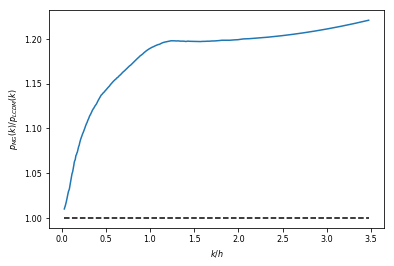

In [32]:
# par = [0.136512329, 0.971, 0.82, 1e-06, 1]
# 11, 17, 20, 37, 46
# params = np.loadtxt(paramIn)

ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
saver = gpflow.saver.Saver()

m1 = saver.load(GPmodel, context=ctx_for_loading)
m1.clear()
m1.compile()

pca_model = pickle.load(open(PCAmodel, 'rb'))



params = np.loadtxt(paramIn)
params.min()
par = params[46]
# par = [1.46428570e-01, 9.56122398e-01, 8.14285755e-01, 2.05061588e-06, 8.16328004e-02] #params[11]
par = [0.14, 1.0, 0.7, 1e-5, 1.0] #params[11]
az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
z_all = az[:, 1]
z_snap = z_all[snap_ID]

# scaled_par = scale01(lhdmin, lhdmax, par)
# print(par)
# print( (scaled_par))

# x_id = 46
# 
# 

# print( params[np.argmin(params[:,3])])
# print(parameter_array_all[x_id])
plt.figure(12)


# emu = MGemu(Om=par[0], ns=par[1], s8=par[2], fR0=par[3], n=par[4], z=z_array[snap_id])
# Emu(scaled_par)
plt.plot(kvals, MGemu(Om=par[0], ns=par[1], s8=par[2], fR0=par[3], n=par[4], z=z_snap))
# plt.plot(kvals, EmuPlusMinus(scaled_par)[0])
# plt.fill_between(kvals, EmuPlusMinus(scaled_par)[1], EmuPlusMinus(scaled_par)[2], alpha = 0.5)
plt.plot(kvals, np.ones_like(kvals), 'k--')

plt.ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
plt.xlabel(r'$k/h$')

plt.show()

./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap96
[1.46428570e-01 9.56122398e-01 8.14285755e-01 3.90693994e-05
 8.16328004e-02]
[0.755102   0.53061199 0.57142877 0.89795918 0.0204082 ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap97
[1.46428570e-01 9.56122398e-01 8.14285755e-01 3.90693994e-05
 8.16328004e-02]
[0.755102   0.53061199 0.57142877 0.89795918 0.0204082 ]
Linear interpolating for redshift between z1= 0.03029 z2= 0.019991
Linear interpolating for snapshots  for z1= 96 and z2= 97
Time per emulation 3.51945  s


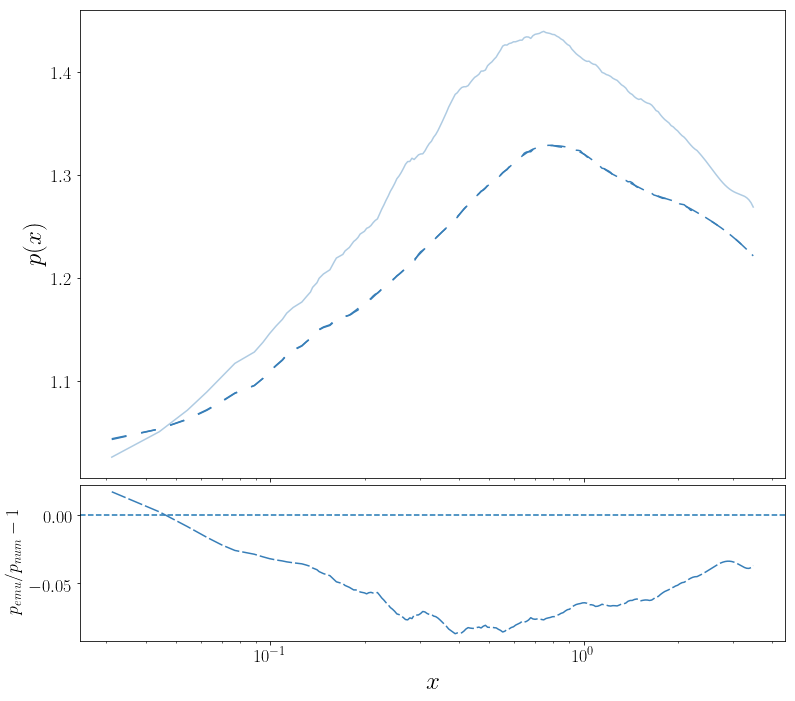

In [38]:
#### GP POSTERIOR DRAWS and PCA RECONSTRUCTIONS ######

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model_rank' +str(nRankMax)+ '.zip')
# pca_model = pickle.load(open(modelDir + 'PCA_model_rank'+str(nRankMax), 'rb'))

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model'+ str(nRankMax) +'.zip')
# m1 = GPy.models.GPRegression.load_model(GPmodel + '.zip')

# ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
# saver = gpflow.saver.Saver()

# m1 = saver.load(GPmodel, context=ctx_for_loading)
# m1.clear()
# m1.compile()

# pca_model = pickle.load(open(PCAmodel, 'rb'))

plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  # 18 usually

plt.figure(999, figsize=(14, 12))
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.02, left=0.2, bottom=0.15)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylabel(r'$p(x)$', fontsize=25)
ax1.set_xlabel(r'$x$', fontsize=25)
ax1.set_ylabel(r'$p_{emu}/p_{num} - 1$', fontsize = 18)
# ax1.set_ylim(-5e-2, 5e-2)

ax0.set_xscale('log')
# ax0.set_yscale('log')
ax1.set_xscale('log')

ax1.axhline(y=0, ls='dashed')

color_id = 0
# del_idx = [4]
for x_id in del_idx:
    color_id = color_id + 1
    time0 = time.time()
#     x_decoded_new = Emu(parameter_array_all[x_id], PCAmodel='PCA_model', GPmodel='GPy_model')
    parameter_array_not_scaled = np.loadtxt(paramIn)
    par_c = parameter_array_not_scaled[x_id]


    x_decoded_new = MGemu(Om=par_c[0], ns=par_c[1], s8=par_c[2], fR0=par_c[3], n=par_c[4], z=z_snap)
    
    # MGemu(Om=par[0], ns=par[1], s8=par[2], fR0=par[3], n=par[4], z=z_snap)
    x_decoded_smooth = scipy.signal.savgol_filter(x_decoded_new , 51, 6)
    
    # ax0.plot(kvals, EmuPlusMinus(parameter_array_all[x_id])[0])
    # ax0.fill_between(kvals, EmuPlusMinus(parameter_array_all[x_id])[1], EmuPlusMinus(parameter_array_all[x_id])[2], alpha = 0.5)

    time1 = time.time()
    print('Time per emulation %0.5f' % (time1 - time0), ' s')
    ax0.plot(kvals, x_decoded_new, alpha=1.0, lw = 1.5, ls='--', label='emu', dashes=(10, 10), color=plt.cm.Set1(color_id))
    ax0.plot(kvals, x_decoded_smooth, alpha=1.0, lw = 1.5, ls='--', label='emu', dashes=(10, 10), color=plt.cm.Set1(color_id))

#     x_test = PmPl_all[x_id]
    x_test = scipy.signal.savgol_filter(PmPl_all[x_id], 51, 6)

    ax0.plot(kvals, x_test, alpha=0.4, label='real', color=plt.cm.Set1(color_id))

    ax1.plot(kvals, (x_decoded_smooth / (x_test) ) - 1, ls='--', dashes=(10, 2), color=plt.cm.Set1(color_id))


ax0.set_xticklabels([])
plt.savefig(plotsDir + 'Pemu_rank' +str(nRankMax) + '.png', figsize=(28, 24), bbox_inches="tight")
plt.show()

In [ ]:
# #### GP POSTERIOR DRAWS and PCA RECONSTRUCTIONS ######

# # m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model_rank' +str(nRankMax)+ '.zip')
# # pca_model = pickle.load(open(modelDir + 'PCA_model_rank'+str(nRankMax), 'rb'))

# # m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model'+ str(nRankMax) +'.zip')
# # m1 = GPy.models.GPRegression.load_model(GPmodel + '.zip')

# ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
# saver = gpflow.saver.Saver()

# m1 = saver.load(GPmodel, context=ctx_for_loading)
# m1.clear()
# m1.compile()

# pca_model = pickle.load(open(PCAmodel, 'rb'))

# plt.rc('text', usetex=True)  # Slower
# plt.rc('font', size=18)  # 18 usually

# plt.figure(999, figsize=(14, 12))
# from matplotlib import gridspec

# gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
# gs.update(hspace=0.02, left=0.2, bottom=0.15)
# ax0 = plt.subplot(gs[0])
# ax1 = plt.subplot(gs[1])

# ax0.set_ylabel(r'$p(x)$', fontsize=25)
# ax1.set_xlabel(r'$x$', fontsize=25)
# ax1.set_ylabel(r'$p_{emu}/p_{num} - 1$', fontsize = 18)
# # ax1.set_ylim(-5e-2, 5e-2)

# ax0.set_xscale('log')
# # ax0.set_yscale('log')
# ax1.set_xscale('log')

# ax1.axhline(y=0, color = 'r')

# color_id = 0
# # del_idx = [4]
# for x_id in del_idx:
#     color_id = color_id + 1
#     time0 = time.time()
#     x_decoded_new = Emu(parameter_array_all[x_id])
#     x_decoded_smooth = scipy.signal.savgol_filter(x_decoded_new , 51, 6)
    
#     ax0.plot(kvals, EmuPlusMinus(parameter_array_all[x_id])[0], ls='--', dashes=(10, 2), color='k')
#     ax0.fill_between(kvals, EmuPlusMinus(parameter_array_all[x_id])[1], EmuPlusMinus(parameter_array_all[x_id])[2], alpha = 0.5)

#     time1 = time.time()
#     print('Time per emulation %0.5f' % (time1 - time0), ' s')
#     # ax0.plot(kvals, x_decoded_new, alpha=1.0, lw = 1.5, ls='--', color = 'k', label='emu', dashes=(10, 10))
#     # ax0.plot(kvals, x_decoded_smooth, alpha=1.0, lw = 1.5, ls='--', color = 'r', label='emu', dashes=(10, 10))

# #     x_test = PmPl_all[x_id]
#     x_test = scipy.signal.savgol_filter(PmPl_all[x_id], 51, 6)

#     # ax0.plot(kvals, x_test, alpha=0.4, label='real', color=plt.cm.Set1(color_id))
#     ax0.plot(kvals, x_test, alpha=0.4, label='real', color='red')

#     ax1.plot(kvals, (x_decoded_smooth / (x_test) ) - 1, ls='--', dashes=(10, 2), color='k')
#     ax1.fill_between(kvals, (EmuPlusMinus(parameter_array_all[x_id])[1]/ (x_test) ) - 1, (EmuPlusMinus(parameter_array_all[x_id])[2]/ (x_test) ) - 1, alpha = 0.5)


# ax0.set_ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
# ax1.set_xlabel(r'$k/h$')

# ax0.set_xticklabels([])
# plt.savefig(plotsDir + 'uq_Pemu_rank' +str(nRankMax) + '.png', figsize=(28, 24), bbox_inches="tight")
# plt.show()

[1.2e-01 8.5e-01 7.0e-01 1.0e-08 0.0e+00]
[1.55e-01 1.05e+00 9.00e-01 1.00e-04 4.00e+00]
[1.37499999e-01 9.49999994e-01 7.99999986e-01 1.16705569e-05
 2.00000007e+00]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap96
[1.37499999e-01 9.49999994e-01 7.99999986e-01 1.16705569e-05
 2.00000007e+00]
[0.49999998 0.49999997 0.49999993 0.7667729  0.50000002]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap97
[1.37499999e-01 9.49999994e-01 7.99999986e-01 1.16705569e-05
 2.00000007e+00]
[0.49999998 0.49999997 0.49999993 0.7667729  0.50000002]
Linear interpolating for redshift between z1= 0.03029 z2= 0.019991
Linear interpolating for snapshots  for z1= 96 and z2= 97
0
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap96
[1.20000000e-01 9.49999994e-01 7.99999986e-01 1.16705569e-05
 2.00000007e+00]
[0.         0.49999997 0.49999993 0.7667729  0.50000002]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap97
[1.20000000e-01 9.49999994e-01 7.99999986e-01 1.16705569e-05
 2.00000007e+00]
[0.         0.4

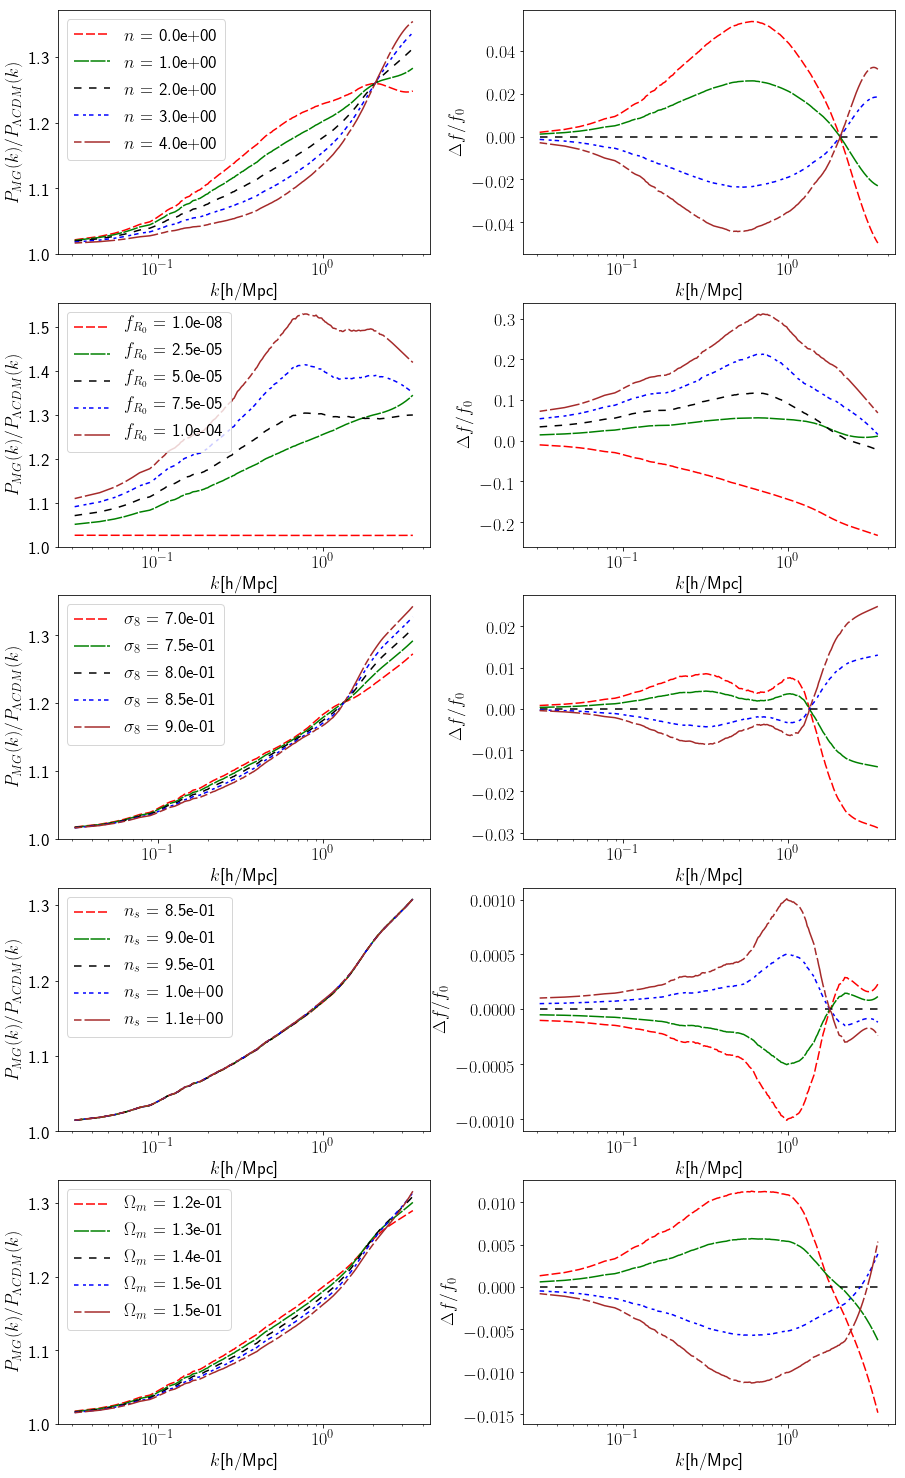

In [43]:
from itertools import cycle
import matplotlib.ticker as ticker
allLabels = [r'${\Omega}_m$', r'$n_s$', r'${\sigma}_8$', r'$f_{R_0}$', r'$n$']

allMax = np.max(parameter_array_not_scaled, axis = 0)
allMin = np.min(parameter_array_not_scaled, axis = 0)
allMean = np.mean(parameter_array_not_scaled, axis = 0)

#allMean = 0.5*(allMax - allMin)

print(allMin)
print(allMax)
print(allMean)
Pk_mean = MGemu(Om=allMean[0], ns=allMean[1], s8=allMean[2], fR0=allMean[3], n=allMean[4], z=z_snap)


PlotCls = True

numPlots = 5

fig, ax = plt.subplots(5,2, figsize = (15,26))
# fig = plt.figure()
# fig.add_subplot(221)   #top left
# fig.add_subplot(222)   #top right
# fig.add_subplot(223)   #bottom left
# fig.add_subplot(224)   #bottom right
# plt.show()
plt.subplots_adjust(wspace=0.25)

if PlotCls:
    for paramNo in range(5):
        print(paramNo)
        para_range = np.linspace(allMin[paramNo], allMax[paramNo], numPlots)

        #plt.figure(32)
        lines = ["-","-.","--",":"]
        linecycler = cycle(lines)
        dashList = [(6,2),(10,1),(5,5),(3,3,2,2),(5,2,20,2)]
        colorList = ['r', 'g', 'k', 'b', 'brown']


        for plotID in range(numPlots):
            para_plot = np.copy(allMean)
            para_plot[paramNo] = para_range[plotID]  #### allMean gets changed everytime!!
            # x_decodedGPy = Emu(para_plot) 
            x_decodedGPy = MGemu(Om=para_plot[0], ns=para_plot[1], s8=para_plot[2], fR0=para_plot[3], n=para_plot[4], z=z_snap)
            lineObj = ax[4-paramNo,0].plot(kvals, x_decodedGPy, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = allLabels[paramNo] + ' = %.1e'%para_range[plotID])
            #ax[paramNo,0].set_ylim(9.9, None)
            #ax[4-paramNo,0].set_yscale('log')
            ax[4-paramNo,0].set_xscale('log')
            ax[4-paramNo,0].set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$')
            ax[4-paramNo,0].set_xlabel('$k$[h/Mpc]')
            #ticks = np.linspace(np.min(10**x_decodedGPy), np.max(10**x_decodedGPy), 5)
            #ticks = np.array([10, 15, 20, 25, 30, 35, 40])
            #ax[4-paramNo,0].set_yticks(ticks, minor = True)
            ax[4-paramNo,0].set_yticks([], minor = True)
            ax[4-paramNo,0].legend(iter(lineObj), para_range.round(decimals=2), title = allLabels[paramNo])
            ax[4-paramNo,0].legend()
            #ax[paramNo,0].legend(title = allLabels[paramNo])
            #ax[paramNo,1].set_yscale('log')
            ax[4-paramNo,1].set_xscale('log')
            ax[4-paramNo,1].set_ylabel(r'$\Delta f / f_0$')
            ax[4-paramNo,1].set_xlabel('$k$[h/Mpc]')
            #ax[paramNo,0].legend(iter(lineObj), para_range.round(decimals=2), title = allLabels[paramNo])
            #ax[paramNo,0].legend(title = allLabels[paramNo])
            ax[4-paramNo,1].plot(kvals, (x_decodedGPy)/(Pk_mean) - 1, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = para_range[plotID] )


        start, end = ax[4-paramNo, 0].get_ylim()
        ax[4-paramNo, 0].yaxis.set_ticks( (np.arange(start, end, 0.1)))
        ax[4-paramNo, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


fig.savefig(plotsDir + "sensitivity_snap" + str(snap_ID) + ".png",  bbox_inches="tight", dpi=200)

plt.show()




In [ ]:

#################################################################################################
#################################################################################################
############################################## MCMC #############################################
#################################################################################################

# import emcee
# import pygtc

# #### parameters that define the MCMC

# ndim = 5
# nwalkers = 800 #600  # 500
# nrun_burn = 100  # 50 # 50  # 300
# nrun = 1000 #700  # 300  # 700


In [20]:
# #### FAKE DATA GENERATION #####


# create_fake_fiducial = False

# if create_fake_fiducial:
#     dirDataIn = "./Data/FiducialData/"

#     seed = 1
#     np.random.seed(seed)

#     Pk_ratio = np.loadtxt(dirDataIn + 'ratios213.txt')[:, 25].T
#     Pk_ratio = (1 + np.random.rand()/100)*Pk_ratio
#     np.savetxt(dirDataIn + 'fiducial_ratio213.txt', Pk_ratio)

#     cov_mat = np.zeros(shape = (Pk_ratio.shape[0], Pk_ratio.shape[0]))

#     for i in range(Pk_ratio.shape[0]):
#         cov_mat[i, i] = (1 + kvals[i]**2)*(1 + np.random.rand())*np.sqrt(Pk_ratio[i])/8000

#     np.savetxt(dirDataIn + 'fiducial_cov213.txt', cov_mat)

In [21]:
# # #### INTERPOLATED COV MATRIX GENERATION #####


# create_cov_interpolate = False

# if create_cov_interpolate:
    
#     ### We have cavariance matrix for 20 bins, convert that to 213
        
#     dirDataIn20 = "./Data/FiducialData/FromSims/"
#     Pk_ratio20 = np.loadtxt(dirDataIn20 + 'ratioavg_97.txt')
#     cov_mat20 = np.loadtxt(dirDataIn20 + 'covariance_97.txt')


#     from scipy import interpolate 

#     dataDir20 = "./Data/Emulator_data/" ## Data folder
#     fileIn20 = dataDir20 + 'ratios_' + str(snap_ID) + '.txt'


#     loadFile20 = np.loadtxt(fileIn20)
#     kvals20 = loadFile20[:,0]

#     x = kvals20
#     y = kvals20
#     z = cov_mat20

#     cov_mat_model = interpolate.interp2d(x, y, z, kind='cubic')

#     xnew = kvals
#     ynew = kvals

#     cov_mat213 = cov_mat_model(xnew, ynew)
    
#     cov_mat = cov_mat213
    

#     Pk_ratio_model = interpolate.CubicSpline(kvals20, Pk_ratio20[:, 1])
    
#     Pk_ratio213 = Pk_ratio_model(kvals)
    
#     Pk_ratio = Pk_ratio213
    
    

In [44]:
# #### COV from 2000 sims #####


cov_load_2000 = True

if cov_load_2000:
    
    ### We have cavariance matrix for 20 bins, convert that to 213
        
    dirDataIn20 = "./Data/FiducialData/FromSims/"
    kvals, Pk_ratio = np.loadtxt(dirDataIn20 + 'ratioavg_97_2000s.txt').T
    cov_mat = np.loadtxt(dirDataIn20 + 'covariance_97_2000s.txt')


    # from scipy import interpolate 

    # dataDir20 = "./Data/Emulator_data/" ## Data folder
    # fileIn20 = dataDir20 + 'ratios_' + str(snap_ID) + '.txt'


    # loadFile20 = np.loadtxt(fileIn20)
    # kvals20 = loadFile20[:,0]

    # x = kvals20
    # y = kvals20
    # z = cov_mat20

    # cov_mat_model = interpolate.interp2d(x, y, z, kind='cubic')

    # xnew = kvals
    # ynew = kvals

    # cov_mat213 = cov_mat_model(xnew, ynew)
    
    # cov_mat = cov_mat213
    

    # Pk_ratio_model = interpolate.CubicSpline(kvals20, Pk_ratio20[:, 1])
    
    # Pk_ratio213 = Pk_ratio_model(kvals)
    
    # Pk_ratio = Pk_ratio213
    
    

In [45]:
# plt.figure(232)

# plt.plot(kvals, Pk_ratio213, 'x')
# plt.plot(kvals20, Pk_ratio20[:, 1], 'o')


# plt.show()

In [46]:
# # This import registers the 3D projection, but is otherwise unused.
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# import matplotlib.pyplot as plt
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# import numpy as np

# # %matplotlib notebook


# fig = plt.figure()
# ax = fig.gca(projection='3d')

# # Make data.
# X = kvals
# Y = kvals
# X, Y = np.meshgrid(X, Y)
# Z = cov_mat

# # Plot the surface.
# surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis,
#                        linewidth=0, antialiased=False, alpha = 0.2)



# # Make data.
# X = kvals20
# Y = kvals20
# X, Y = np.meshgrid(X, Y)
# Z = cov_mat20

# # Plot the surface.
# surf = ax.plot_surface(X, Y, Z, cmap=cm.inferno,
#                        linewidth=0, antialiased=False, alpha = 0.4)






# # Customize the z axis.
# # ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.8, aspect=5)

# plt.show()

In [47]:
#### cov mat smoothing

# import scipy.ndimage as spi
# sigma_y = sigma_x = 0.0
# sigma = [sigma_y, sigma_x]
# cov_mat = spi.filters.gaussian_filter(cov_mat, sigma, mode='constant')


In [48]:
# cov_mat.shape

In [49]:
########## REAL DATA with ERRORS #############################

# Pk_ratio = np.loadtxt(dirDataIn + 'fiducial_ratio213.txt')
# cov_mat = np.loadtxt(dirDataIn + 'fiducial_cov213.txt')

# dirDataIn = "./Data/FiducialData/FromSims/"
# Pk_ratio = np.loadtxt(dirDataIn + 'ratioavg_97.txt')
# cov_mat = np.loadtxt(dirDataIn + 'covariance_97.txt')

# kvals_max = 3.2
# kvals_cond = np.where(Pk_ratio < kvals_max)
kvals_cond = True

x = np.array(kvals)
y = Pk_ratio
yerr_diag = np.sqrt(np.diag(cov_mat))#[:, 0]



# x = x[kvals_cond]
# y = y[kvals_cond]

yerr_diag = yerr_diag[kvals_cond][0]
# emax = emax[ls_cond][:,ls_cond][:,0,:]
# cov_mat =  cov_mat[:len(kvals_cond[0]), :len(kvals_cond[0])]
## Only works if slicing is done at a corner.
# i.e., if ls_cond corresponds to continuous array entries in l
# icov = np.linalg.inv(cov_mat)


icov = np.linalg.pinv(cov_mat)

# Moore-Penrose pseudo-inverse of a matrix.



In [50]:
# Pk_ratio.shape

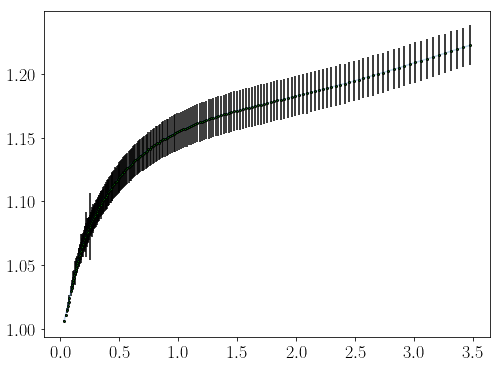

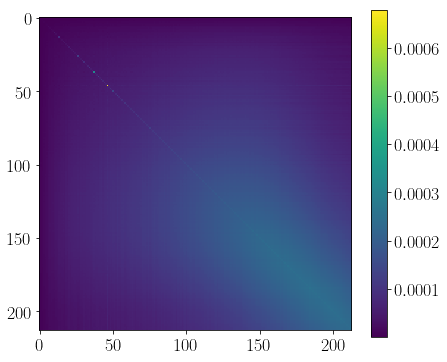

In [51]:
plt.figure(34, figsize = (8, 6))
# np.sqrt(yerr[::5])/Cl[::5]
plt.errorbar(x[::], y[::], yerr= yerr_diag[::] , marker='o',
       color='k',
       ecolor='k',
       markerfacecolor='g',
       markersize = 2,
       capsize=0,
       linestyle='None')


# plt.plot(kvals, np.loadtxt(dirDataIn + 'ratios213.txt')[:, 1:], alpha = 0.3)
plt.plot(kvals, Pk_ratio, alpha = 0.3)
# plt.xscale('log')
# plt.show()

plt.savefig('Plots/PowerSpect_emu.pdf')


plt.figure(43, figsize = (7, 6))
plt.imshow(cov_mat)
plt.colorbar()
# plt.show()

plt.savefig('Plots/Cov_mat.pdf')


In [52]:
# y.shape

In [53]:
# kvals.shape

In [54]:

# #### Cosmological Parameters ########################################

# parameter_array_all.min(axis=0)

# para1 = [allLabels[0], 0.1188, 0.12, 0.155]  # Actual 0.119
# para2 = [allLabels[1], 0.02230, 0.0215, 0.0235]
# para3 = [allLabels[2], 0.8159, 0.7, 0.89]
# para4 = [allLabels[3], 0.6774, 0.55, 0.85]
# para5 = [allLabels[4], 0.9667, 0.85, 1.05]


In [71]:

#### Cosmological Parameters ########################################

allMin = parameter_array_not_scaled.min(axis=0)
allMax = parameter_array_not_scaled.max(axis=0)
# allMean = parameter_array_all.mean(axis=0)
# allMean = parameter_array_all[25]

allMean = [0.141745, 0.9667, 0.8159, 1e-5, 1.0]


# Ω_m*h^2=0.141745, n_s=0.9667, σ_8 = 0.8159 and for the MG part f_r0=10^-5 and n=1

para1 = [allLabels[0], allMean[0], allMin[0], allMax[0]]  # Actual 0.119
para2 = [allLabels[1], allMean[1], allMin[1], allMax[1]]
para3 = [allLabels[2], allMean[2], allMin[2], allMax[2]]
para4 = [allLabels[3], allMean[3], allMin[3], allMax[3]]
para5 = [allLabels[4], allMean[4], allMin[4], allMax[4]]


In [72]:
# para4

In [73]:
# #################### CHAIN INITIALIZATION ##########################

# ## 2 options

# Uniform_init = True
# if Uniform_init:
#     # Choice 1: chain uniformly distributed in the range of the parameters
#     pos_min = np.array( [para1[2], para2[2], para3[2], para4[2], para5[2]] )
#     pos_max = np.array( [para1[3], para2[3], para3[3], para4[3], para5[3]] )
#     psize = pos_max - pos_min
#     pos0 = [pos_min + psize * np.random.rand(ndim) for i in range(nwalkers)]

# True_init = False
# if True_init:
#     # Choice 2: chain is initialized in a tight ball around the expected values
#     pos1 = [[para1[1] * 1.2, para2[1] * 0.8, para3[1] * 0.9, para4[1] * 1.1, para5[1] * 1.2] +
#             1e-3 * np.random.randn(ndim) for i in range(nwalkers)]

# MaxLikelihood_init = False
# if MaxLikelihood_init:
#     # Choice 2b: Find expected values from max likelihood and use that for chain initialization
#     # Requires likehood function below to run first

#     import scipy.optimize as op

#     nll = lambda *args: -lnlike(*args)
#     result = op.minimize(nll, [para1[1], para2[1], para3[1], para4[1], para5[1]], args=(x, y, icov))
#     p1_ml, p2_ml, p3_ml, p4_ml, p5_ml = result["x"]
#     print(result['x'])

#     pos0 = [result['x'] + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]


In [74]:
# np.array(pos0).shape

In [75]:
# pygtc.plotGTC(pos)

In [76]:
# # Visualize the initialization

# PriorPlot = False

# if PriorPlot:
#     fig = pygtc.plotGTC(pos0, labels=[para1[0], para2[0], para3[0], para4[0], para5[0]],
#                         range=[[para1[2], para1[3]], [para2[2], para2[3]],
#                                [para3[2], para3[3]],
#                                [para4[2], para4[3]], [para5[2], para5[3]]],
#                         truths=[para1[1], para2[1], para3[1], para4[1], para5[1]])
#     fig.set_size_inches(10, 10)

# ######### not working #######################

In [77]:
# allMin

In [78]:
# allMax

In [79]:
p1, p2, p3, p4, p5 = allMean

In [80]:
if (para1[2] < p1 < para1[3] and para2[2] < p2 < para2[3] and para3[2] < p3 < para3[3] and para4[2] < p4 < para4[3] and para5[2] < p5 < para5[3]):
        print('Success')
print('fail')

Success
fail


In [81]:
def lnprior(theta):
    p1, p2, p3, p4, p5 = theta
    # if 0.12 < p1 < 0.155 and 0.7 < p2 < 0.9:
    if (para1[2] < p1 < para1[3] and para2[2] < p2 < para2[3] and para3[2] < p3 < para3[3] and para4[2] < p4 < para4[3] and para5[2] < p5 < para5[3]):
        return 0.0
    return -np.inf


In [82]:
def lnprior_gauss(theta):
    p1, p2, p3, p4, p5 = theta
    #flat priors on b, c
#     if not 1.0 < b < 2.0 and 1.0 < c < 2.0:
    if not (para4[2] < p4 < para4[3] and para5[2] < p5 < para5[3]):
        return -np.inf
    #gaussian prior on a
    mu_para1 = para1[1]
    sigma_para1 = np.abs(para1[2] - para1[3])/4
#     lnprior1 =  np.log(1.0/(np.sqrt(2*np.pi)*sigma_para1))-0.5*(p1-mu_para1)**2/sigma_para1**2
    lnprior1 =  -0.5*(p1-mu_para1)**2/sigma_para1**2
    
        #gaussian prior on d
    mu_para2 = para2[1]
    sigma_para2 = np.abs(para2[2] - para2[3])/4
#     lnprior2 =  np.log(1.0/(np.sqrt(2*np.pi)*sigma_para2))-0.5*(p2-mu_para2)**2/sigma_para2**2
    lnprior2 =  -0.5*(p2-mu_para2)**2/sigma_para2**2
    
        #gaussian prior on e
    mu_para3 = para3[1]
    sigma_para3 = np.abs(para3[2] - para3[3])/4
#     lnprior3 =  np.log(1.0/(np.sqrt(2*np.pi)*sigma_para3))-0.5*(p3-mu_para3)**2/sigma_para3**2
    lnprior3 =  -0.5*(p3-mu_para3)**2/sigma_para3**2
    
    return (lnprior1 + lnprior2 + lnprior3)
    
    

In [84]:
lnprior([0.1, 1.1, 0.8, 3e-5, 1.5])

-inf

In [85]:
######### TEMPLATE FOR MCMC LIKELIHOOD FUNCTION #######################
# For emcee

# def lnlike_diag(theta, x, y, yerr):
#     p1, p2, p3, p4, p5 = theta

#     new_params = np.array([p1, p2, p3, p4, p5])

#     model = Emu(new_params)
#     return -0.5 * (np.sum(((y - model) / yerr) ** 2.))
# #     return -0.5 * (np.sum(((y - model) / yerr) ** 2.))


# def lnlike_full(theta, x, y, icov):
#     p1, p2, p3, p4, p5 = theta

#     new_params = np.array([p1, p2, p3, p4, p5])

#     model = Emu(new_params)
    
#     y_model = np.asarray(y-model)
#     icov = np.asarray(icov)
#     return -0.5*(y_model.dot(icov).dot(y_model))

## likelihood with reduced k-values

def lnlike(theta, x, y, icov):
    p1, p2, p3, p4, p5 = theta
    
#     kval_cut = 1.0
    truncated_kvals = np.where(x < kval_cut)
    
    new_params = np.array([p1, p2, p3, p4, p5])

    icov = np.asarray(icov)
    
    
    # model = Emu(new_params)
    model = MGemu(p1, p2, p3, p4, p5, z_snap)
    
    model_red = model[truncated_kvals]
    icov_red = icov[0: np.array(truncated_kvals)[0][-1] + 1, 0: np.array(truncated_kvals)[0][-1] + 1]
    x_red = x[truncated_kvals]
    y_red = y[truncated_kvals]
    
    y_model = np.asarray(y_red-model_red)

    
    loglike = -0.5*(y_model.dot(icov_red).dot(y_model))
    return loglike

In [86]:



# def lnprob(theta, x, y, yerr):
#     lp = lnprior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     # return lp + lnlike_diag(theta, x, y, yerr)
#     return lp + lnlike(theta, x, y, yerr)


def lnprob(theta, x, y, yerr):
    lp = lnprior_gauss(theta)
#     lp = lnprior(theta)

    if not np.isfinite(lp):
        return -np.inf
    # return lp + lnlike_diag(theta, x, y, yerr)
    return lp + lnlike(theta, x, y, yerr)
############################# PARAMETERS ##############################

In [87]:
theta0 = [0.1, 1.1, 0.8, 3e-5, 1.5]
icov = icov
x = np.array(kvals)
y = Pk_ratio
kval_cut = 0.1
lnlike(theta0, x, y, icov)

./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap96
[1.0e-01 1.1e+00 8.0e-01 3.0e-05 1.5e+00]
[-0.57142857  1.25        0.5         0.86928031  0.375     ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap97
[1.0e-01 1.1e+00 8.0e-01 3.0e-05 1.5e+00]
[-0.57142857  1.25        0.5         0.86928031  0.375     ]
Linear interpolating for redshift between z1= 0.03029 z2= 0.019991
Linear interpolating for snapshots  for z1= 96 and z2= 97


-2772.0057547106326

In [89]:

def dPdt(param_idx, step):

    step_params = step*fid_params[param_idx]
    
    para_idx_array = np.zeros_like(fid_params)
    para_idx_array[param_idx] = 1
    fid_params_l = fid_params + step_params*para_idx_array*fid_params
    
#     fid_params_l[4] = 10**fid_params_l[4]
    # model_l = Emu(fid_params_l)
    model_l = MGemu(fid_params_l[0], fid_params_l[1],fid_params_l[2],fid_params_l[3],fid_params_l[4],z_snap)
    model_l = model_l[truncated_kvals]
    
    fid_params_r = fid_params - step_params*para_idx_array*fid_params
    
#     fid_params_r[4] = 10**fid_params_r[4]
    model_r = MGemu(fid_params_r[0], fid_params_r[1],fid_params_r[2],fid_params_r[3],fid_params_r[4],z_snap)

    # model_r = Emu(fid_params_r)  
    model_r = model_r[truncated_kvals]

    dPdt = (model_r - model_l) / (2.0 * step_params)
    return dPdt

In [90]:
fid_params = np.array([para1[1], para2[1], para3[1], para4[1], para5[1]])
# fid_params = np.array([para1[1], para2[1], para3[1], np.log10(para4[1]), para5[1]])
icov = np.asarray(icov)
x = np.array(kvals)
y = Pk_ratio
kval_cut = 0.7
truncated_kvals = np.where(x < kval_cut)

icov_red = icov[0: np.array(truncated_kvals)[0][-1] + 1, 0: np.array(truncated_kvals)[0][-1] + 1]

# import scipy.ndimage as spi
# sigma_y = sigma_x = 10
# sigma = [sigma_y, sigma_x]
# icov_red = spi.filters.gaussian_filter(icov_red, sigma, mode='constant')


x_red = x[truncated_kvals]
y_red = y[truncated_kvals]

In [91]:
(dPdt(2, 0.01)*icov_red*dPdt(3, 0.01)).shape
icov_red.shape

./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap96
[1.41745000e-01 9.66700000e-01 8.22556928e-01 1.00000000e-05
 1.00000000e+00]
[0.62128571 0.5835     0.61278464 0.75       0.25      ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap97
[1.41745000e-01 9.66700000e-01 8.22556928e-01 1.00000000e-05
 1.00000000e+00]
[0.62128571 0.5835     0.61278464 0.75       0.25      ]
Linear interpolating for redshift between z1= 0.03029 z2= 0.019991
Linear interpolating for snapshots  for z1= 96 and z2= 97
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap96
[1.41745000e-01 9.66700000e-01 8.09243072e-01 1.00000000e-05
 1.00000000e+00]
[0.62128571 0.5835     0.54621536 0.75       0.25      ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap97
[1.41745000e-01 9.66700000e-01 8.09243072e-01 1.00000000e-05
 1.00000000e+00]
[0.62128571 0.5835     0.54621536 0.75       0.25      ]
Linear interpolating for redshift between z1= 0.03029 z2= 0.019991
Linear interpolating for snapshots  for z1= 96 and z2= 97
./

(112, 112)

In [92]:
def fiducial(icov):
    step = 0.01
#     fid_ij = np.zeros(shape=(fid_params.shape[0], fid_params.shape[0], icov_red.shape[0], icov_red.shape[1]) )
    fid_ij = np.zeros(shape=(fid_params.shape[0], fid_params.shape[0] ) )
    
    for i in range(fid_params.shape[0]):
        for j in range(fid_params.shape[0]):
#             fid_ij[i, j] = np.dot(dPdt(i, step), np.dot(icov, dPdt(i, step)) )
#           fid_ij[i, j] = (dPdt(i, step)*icov_red*dPdt(j, step))
#           fid_ij[i, j] = np.dot(np.dot(icov_red,dPdt(i, step)), np.dot(icov_red, dPdt(j, step)))
          fid_ij[i, j] = np.dot(dPdt(i, step), np.dot(icov_red, dPdt(j, step)))

    
#             print(fid_ij.shape)
    return fid_ij

fid_ij = fiducial(icov_red)

cov_plot = np.linalg.pinv(fid_ij)

# plt.figure(23, figsize=(4,4))

# f, ax = plt.subplots(5, 5, figsize = (20,20))

# for i in range(5):
#     for j in range(5):

#         if (j > i): ax[i, j].axis('off')
#         else:
# #             ax[i, j].contour( np.linalg.pinv(fid_ij[i, j]), 1)
# #             ax[i, j].contour( (fid_ij[i, j]), 1)
#             ax[i, j].contour( cov_plot[i, j], 4)
# plt.show()
fid_ij.shape

h_rank16snap97
[1.41745e-01 9.66700e-01 8.15900e-01 1.00000e-05 1.01000e+00]
[0.62128571 0.5835     0.5795     0.75       0.2525    ]
Linear interpolating for redshift between z1= 0.03029 z2= 0.019991
Linear interpolating for snapshots  for z1= 96 and z2= 97
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap96
[1.41745e-01 9.66700e-01 8.15900e-01 1.00000e-05 9.90000e-01]
[0.62128571 0.5835     0.5795     0.75       0.2475    ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap97
[1.41745e-01 9.66700e-01 8.15900e-01 1.00000e-05 9.90000e-01]
[0.62128571 0.5835     0.5795     0.75       0.2475    ]
Linear interpolating for redshift between z1= 0.03029 z2= 0.019991
Linear interpolating for snapshots  for z1= 96 and z2= 97
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap96
[1.4174500e-01 9.6670000e-01 8.1590000e-01 1.0000001e-05 1.0000000e+00]
[0.62128571 0.5835     0.5795     0.75000001 0.25      ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap97
[1.4174500e-01 9.6670000e-01 8.1590000e-0

(5, 5)

(112, 112)


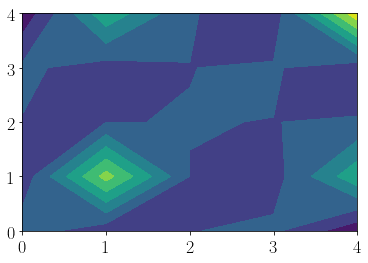

In [95]:
print(icov_red.shape)
cov_ij = np.linalg.pinv(fid_ij)
plt.contourf(cov_ij)

generating new axis
['${\\Omega}_m$', '$n_s$', '${\\sigma}_8$', '$f_{R_0}$', '$n$']


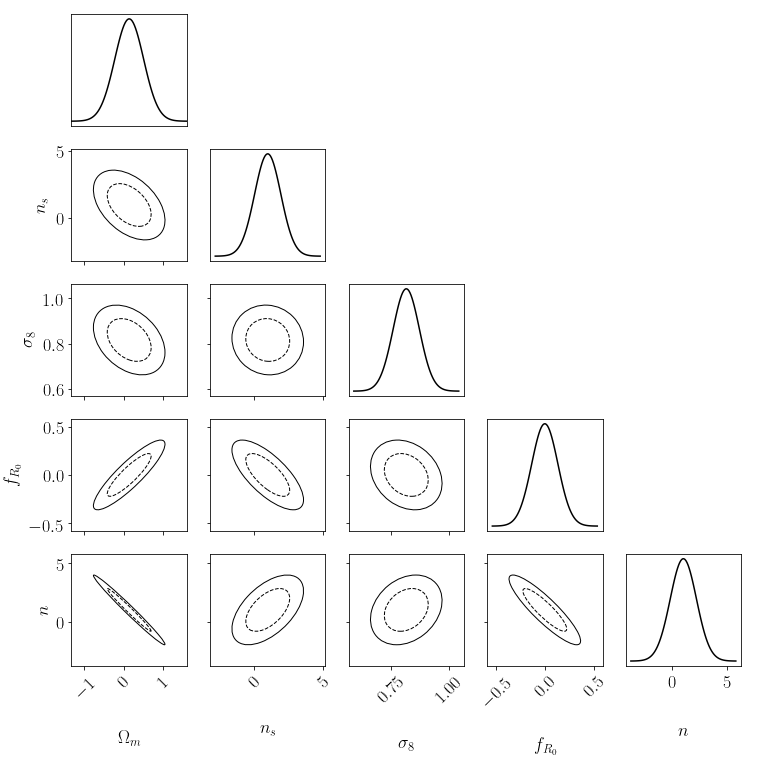

In [96]:
import numpy as np
import fishchips.util


# import scipy.ndimage as spi
# sigma_y = sigma_x = 0.01
# sigma = [sigma_y, sigma_x]
# cov_fid = spi.filters.gaussian_filter(cov, sigma, mode='constant')



# cov = cov_fid
labels =  allLabels # [r'$\omega_b$', r'$\omega_{cdm}$', r'$h$',  r'$A_s$', r'$n_s$', r'$\tau_{reio}$']
pars = np.array(['Omega_m', 'n_s', 'sigma_8', 'f_R_0', 'n'])
centers = fid_params #np.array([0.02222,  0.1197,  0.69,  2.1955e-9, 0.9655, 0.06])
# fig, axes = fishchips.util.plot_triangle_base(pars, centers, cov, labels=labels)
fig, axes = fishchips.util.plot_triangle_base(pars, centers, cov_ij, labels=labels)

plt.savefig('fisher_2000')

In [97]:
    import itertools
    def get_fisher(step = 0.01):
        """Compute the Fisher matrix."""
        npar = 5 #len(obs.parameters)
        fisher = np.zeros((npar, npar))
        para_idx_array = np.zeros_like(fid_params)
        
        fid_kappa = y_red #get_Pkappa(obs.cosmos['CLASS_fiducial'])
        # compute derivatives for each parameter
#         dCl = [(self.get_Pkappa(obs.cosmos[obs.parameters[i] + '_CLASS_right'])- self.get_Pkappa(obs.cosmos[obs.parameters[i] + '_CLASS_left'])) /(obs.right[i] - obs.left[i]) for i in range(npar)]
        dCl = [Emu(fid_params + step*fid_params[i]*para_idx_array*fid_params) - Emu(fid_params + step*fid_params[i]*para_idx_array*fid_params) /(2*step*fid_params[i]) for i in range(npar)]
        fisher_ell = np.zeros_like(x_red) #np.zeros(self.l_max)
        
        print(np.array(dCl).shape, x_red.shape)
        
        for i, j in itertools.combinations_with_replacement(range(npar), r=2):
            # compute covariance matrix
            fisher_sum = 0.0
#             for l in range(x_red.min(), x_red.max()):
            for l in range(x_red.shape[0]):
#             for l in range(npar):


#                 Cmat = np.array([[fid_kappa[l] + self.sigma_e**2/self.ngal]])
                invC = icov #np.linalg.inv(Cmat)
                term = np.dot(np.dot(invC,dCl[i][l]), np.dot(invC,dCl[j][l]))
                summand = np.trace(term) #(l+0.5) * self.fsky * np.trace(term)
                
                fisher_sum += summand
#                 if i == j and obs.parameters[i] == 'm_ncdm':
#                     fisher_ell[l] += summand

            fisher[i, j] = fisher_sum
            fisher[j, i] = fisher_sum
                
        return fisher

In [99]:
# step_params = step*fid_params[param_idx]
fisher = get_fisher(step=0.01)
cov = np.linalg.pinv(fisher)

plt.figure(figsize=(12,10))
plt.contourf(cov, 5)
plt.colorbar()


TypeError: Emu() missing 2 required positional arguments: 'pcamodel' and 'para_array'

In [98]:
import numpy as np
import fishchips.util


# import scipy.ndimage as spi
# sigma_y = sigma_x = 0.01
# sigma = [sigma_y, sigma_x]
# cov_fid = spi.filters.gaussian_filter(cov, sigma, mode='constant')



# cov = cov_fid
labels =  allLabels # [r'$\omega_b$', r'$\omega_{cdm}$', r'$h$',  r'$A_s$', r'$n_s$', r'$\tau_{reio}$']
pars = np.array(['Omega_m', 'n_s', 'sigma_8', 'f_R_0', 'n'])
centers = allMean #np.array([0.02222,  0.1197,  0.69,  2.1955e-9, 0.9655, 0.06])
# fig, axes = fishchips.util.plot_triangle_base(pars, centers, cov, labels=labels)
fig, axes = fishchips.util.plot_triangle_base(pars, centers, cov, labels=labels)

NameError: name 'cov' is not defined

In [163]:
lnlike(fid_params, x_red, y_red, icov_red)

-19.04085227796479

In [164]:
def d2Pdt(param_idx0, param_idx1, step0, step1):
#     http://www.holoborodko.com/pavel/numerical-methods/numerical-derivative/central-differences/

    step_params0 = step0*fid_params[param_idx0]
    step_params1 = step1*fid_params[param_idx1]
    
    para_idx_array0 = np.zeros_like(fid_params)
    para_idx_array1 = np.zeros_like(fid_params)
    
    para_idx_array0[param_idx0] = 1
    para_idx_array1[param_idx1] = 1
    
    fid_params_00 = fid_params - step_params0*para_idx_array0*fid_params - step_params1*para_idx_array1*fid_params
    model_00 = lnlike(fid_params_00, x_red, y_red, icov_red)#[truncated_kvals]
    
    fid_params_11 = fid_params + step_params0*para_idx_array0*fid_params + step_params1*para_idx_array1*fid_params
    model_11 = lnlike(fid_params_11, x_red, y_red, icov_red)#[truncated_kvals]
    
    fid_params_10 = fid_params + step_params0*para_idx_array0*fid_params - step_params1*para_idx_array1*fid_params
    model_10 = lnlike(fid_params_10, x_red, y_red, icov_red)#[truncated_kvals]
    
    fid_params_01 = fid_params - step_params0*para_idx_array0*fid_params + step_params1*para_idx_array1*fid_params
    model_01 = lnlike(fid_params_01, x_red, y_red, icov_red)#[truncated_kvals]

    d2Pdt = (model_00 + model_11 - model_10 - model_01) / (4.0*step_params0*step_params1)
    return d2Pdt
            

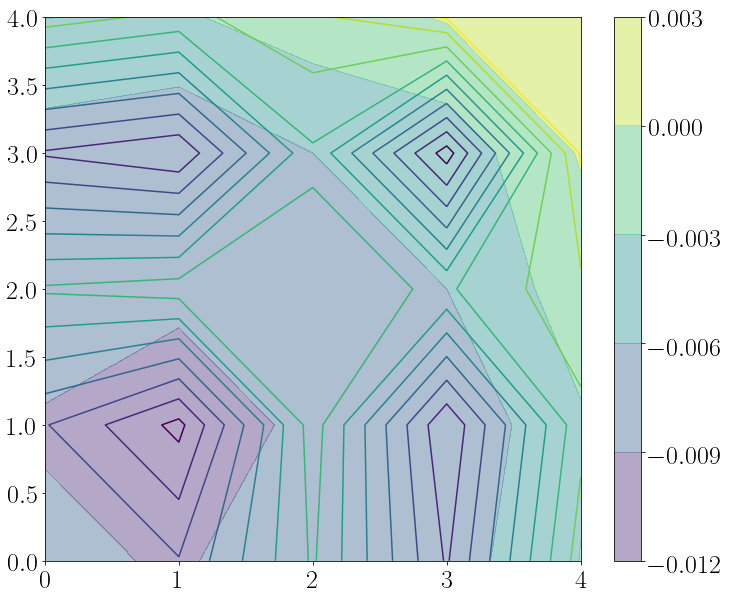

In [165]:
fid = np.zeros(shape=(5,5))
step0 = step1 = 0.01

for i in range(5):
    for j in range(5):
        fid[i, j] = d2Pdt(i, j, step0, step1)
        
        
cov_fid = np.linalg.pinv(fid)

import scipy.ndimage as spi
sigma_y = 0.8
sigma_x = 0.8
sigma = [sigma_y, sigma_x]
cov_fid_smooth = spi.filters.gaussian_filter(cov_fid, sigma, mode='constant')
# cov_fid_smooth = cov_fid

plt.figure(figsize=(12, 10))    
plt.contour(cov_fid, 10)
plt.contourf(cov_fid_smooth, 4, alpha = 0.4)
plt.colorbar()
plt.show()

generating new axis
['${\\Omega}_m$', '$n_s$', '${\\sigma}_8$', '$f_{R_0}$', '$n$']
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/fishchips-0.0.1-py3.7.egg/fishchips/util.py:238: RuntimeWarning: invalid value encountered in sqrt
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/fishchips-0.0.1-py3.7.egg/fishchips/util.py:68: RuntimeWarning: invalid value encountered in sqrt
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/fishchips-0.0.1-py3.7.egg/fishchips/util.py:69: RuntimeWarning: invalid value encountered in sqrt


ValueError: Axis limits cannot be NaN or Inf

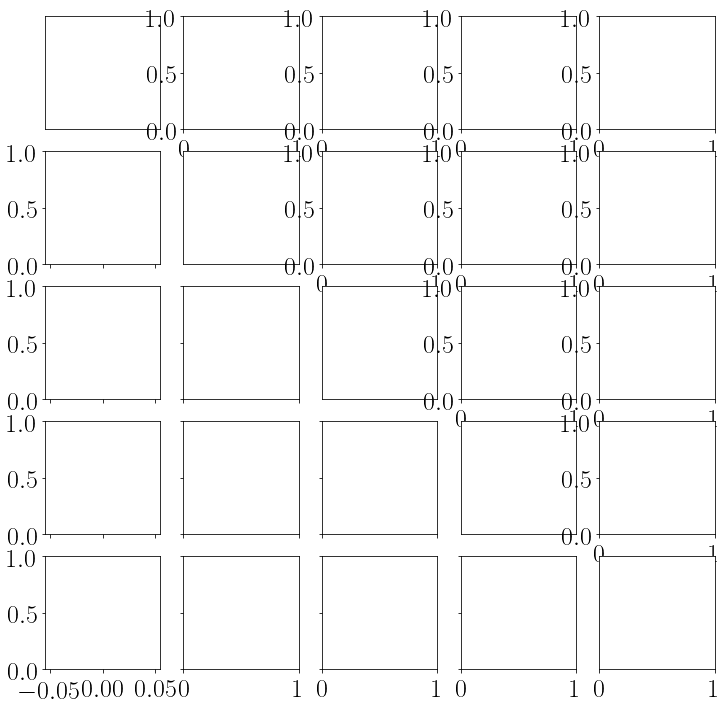

In [166]:
import numpy as np
import fishchips.util


# import scipy.ndimage as spi
# sigma_y = sigma_x = 0.01
# sigma = [sigma_y, sigma_x]
# cov_fid = spi.filters.gaussian_filter(cov, sigma, mode='constant')



# cov = cov_fid
labels =  allLabels # [r'$\omega_b$', r'$\omega_{cdm}$', r'$h$',  r'$A_s$', r'$n_s$', r'$\tau_{reio}$']
pars = np.array(['Omega_m', 'n_s', 'sigma_8', 'f_R_0', 'n'])
centers = allMean #np.array([0.02222,  0.1197,  0.69,  2.1955e-9, 0.9655, 0.06])
# fig, axes = fishchips.util.plot_triangle_base(pars, centers, cov, labels=labels)
fig, axes = fishchips.util.plot_triangle_base(pars, centers, cov_fid_smooth, labels=labels)

In [0]:
allLabels

In [0]:

# ######### MCMC #######################


# ## Sample implementation :
# # http://eso-python.github.io/ESOPythonTutorials/ESOPythonDemoDay8_MCMC_with_emcee.html
# # https://users.obs.carnegiescience.edu/cburns/ipynbs/Emcee.html


# # Let us setup the emcee Ensemble Sampler
# # It is very simple: just one, self-explanatory line

# # sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr_diag))
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, icov))

# ###### BURIN-IN #################

# time0 = time.time()
# # burnin phase
# pos, prob, state = sampler.run_mcmc(pos0, nrun_burn)
# sampler.reset()
# time1 = time.time()
# print('burn-in time:', time1 - time0)

In [0]:


# ###### MCMC ##################
# time0 = time.time()
# # perform MCMC
# pos, prob, state = sampler.run_mcmc(pos, nrun)
# time1 = time.time()
# print('mcmc time:', time1 - time0)


# ###########################################################################

In [0]:
# samples = sampler.flatchain
# samples.shape

# # samples[:, 3] = np.log10(samples[:, 3])

# # samples_plot = sampler.chain[:, :, :].reshape((-1, ndim))
# sampler_chain = sampler.chain[:, :, :]#.reshape((-1, ndim))


In [0]:
# sampler_chain[:,:,3]

In [0]:
# sampler_chain[:, :, 3] = np.log10(sampler_chain[:, :, 3] )

In [0]:

# ###########################################################################


# np.savetxt('Data/Chains/SamplerPCA_mcmc_ndim' + str(ndim) + '_nwalk' + str(nwalkers) + '_run' + str(
#     nrun) + '.txt', sampler_chain.reshape((-1, ndim)))

# ####### FINAL PARAMETER ESTIMATES #######################################



In [0]:

# samples_plot = np.loadtxt('Data/Chains/SamplerPCA_mcmc_ndim' + str(ndim) + '_nwalk' + str(
#     nwalkers) + '_run' + str(nrun) + '.txt')

# # samples = np.exp(samples)
# p1_mcmc, p2_mcmc, p3_mcmc, p4_mcmc, p5_mcmc = map(lambda v: (v[1], v[2] - v[1],
#                                                                                v[1] - v[0]) , zip(*np.percentile(samples_plot, [16, 50, 84], axis=0)))
# print('mcmc results:', p1_mcmc[0], p2_mcmc[0], p3_mcmc[0], p4_mcmc[0], p5_mcmc[0])


In [0]:
# samples_plot[:,:2].shape

In [0]:
####### CORNER PLOT ESTIMATES #######################################

CornerPlot = True
if CornerPlot:

    fig = pygtc.plotGTC(samples_plot,
                        paramNames=[para1[0], para2[0], para3[0], r'$log_{10}($'+para4[0] + r'$)$', para5[0]],
                        truths=[para1[1], para2[1], para3[1], np.log10(para4[1]), para5[1]],
                        figureSize='MNRAS_page')  # , plotDensity = True, filledPlots = False,\smoothingKernel = 0, nContourLevels=3)

    fig.savefig('Plots/pygtcPCA_' + str(ndim) + '_nwalk' + str(nwalkers) + '_run' + str(
        nrun) +  '.pdf')

####### FINAL PARAMETER ESTIMATES #######################################

In [0]:
pfits = np.array([p1_mcmc[0], p2_mcmc[0], p3_mcmc[0], 10**(p4_mcmc[0]), p5_mcmc[0]])
fid_cosmo = np.array(allMean)

plt.figure(3111, figsize = (8, 6))
# np.sqrt(yerr[::5])/Cl[::5]
plt.errorbar(x[::], y[::], yerr= yerr_diag[::] , marker='o',
       color='k',
       ecolor='k',
       markerfacecolor='g',
       markersize = 2,
       capsize=0,
       linestyle='None', alpha = 0.3, label = 'fiducial cosmology')

plt.plot(x[::], Emu(fid_cosmo), label = 'emulated at fiducial cosmology')
plt.plot(x[::], Emu(pfits), label = 'emulated at best fit')

plt.xscale('log')
plt.legend()
plt.show()

In [0]:





# import numpy
# lnlike([0.1, 1.1, 0.8, 3e-5, 1.5], x, y, yerr_diag)

In [0]:
lnprior([0.1, 1.1, 0.8, 3e-5, 1.5])

In [0]:
pos0[0]

In [0]:
[para1[2], para2[2], para3[2], para4[2], para5[2]]


In [0]:
samplerlnprob = (sampler.lnprobability)


In [0]:
plt.figure(2323, figsize = (10,10))
plt.plot(samplerlnprob.T)
# plt.yscale('symlog')
plt.show()

In [0]:
plt.figure(23)
plt.hist(samplerlnprob[:, -1], 200, alpha = 0.4)
plt.hist(samplerlnprob[:, -1][samplerlnprob[:, -1] > -100], 10, alpha = 0.4)
# plt.hist(samplerlnprob[:, -1][samplerlnprob[:, -1] > -30], 10, alpha = 0.4)

In [0]:
####### CORNER PLOT ESTIMATES #######################################

new_samples = sampler.chain[samplerlnprob[:, -1] > -110][:, :, :].reshape((-1, ndim))


CornerPlot = True
if CornerPlot:

    fig = pygtc.plotGTC(new_samples,
                        paramNames=[para1[0], para2[0], para3[0], r'$log_{10}($'+para4[0] + r'$)$', para5[0]],
                        truths=[para1[1], para2[1], para3[1], np.log10(para4[1]), para5[1]],
                        figureSize='MNRAS_page', nContourLevels = 3)# , plotDensity = True, filledPlots = True,smoothingKernel = 0, nContourLevels= 3)

    fig.savefig('Plots/pygtcPCA_' + str(ndim) + '_nwalk' + str(nwalkers) + '_run' + str(
        nrun) +  '.pdf')

####### FINAL PARAMETER ESTIMATES #######################################

In [0]:
# tau = sampler.get_autocorr_time()
# autocorr[index] = np.mean(tau)

In [0]:
import matplotlib.pyplot as plt

n = 100*np.arange(1, index+1)
y = autocorr[:index]
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1*(y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

In [0]:
# Compute the estimators for a few different chain lengths
chain = sampler.chain#[:, :, 0].T


N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chain[:, :n])
    new[i] = autocorr_new(chain[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);